# 実験3-5 自己教師あり学習

自己教師あり学習は，比較的最近に提案された学習手法で，ラベルを必要としない教師なし学習の手法として着目されています．
その基本的な考え方は，

- 同じデータから派生されるデータ拡張は同じ（似たような）表現にマップされるべき
- 異なるデータ（のデータ拡張）は，異なる表現になるべき

というアイディアに基づいた学習手法です．
教師あり学習では，ラベルとよばれる絶対的な指標がありますが，ここでは，表現が似るべきというわりと曖昧なコンセプトに基づいて学習を考えていきます．

ここでは SimCLR （の簡易版）を考えてみます．
キーポイントはデータ拡張の部分にあります．

ここではランダムな，画像切り抜き，フリップ，色補正などを考えています．
データセットとしては `CIFAR10` を考えます．

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset


# 基本となるデータセットの設定
# base_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=None)
base_dataset = datasets.STL10(root="./data", split='train', download=True, transform=None) # ラベルなしが使えるぽい

# cifar10_labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
stl10_labels_map = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
labels_map = stl10_labels_map

# STL-10 は 96x96 の画像サイズ
# CIFAR-10 は 32x32 の画像サイズ
# なので，CIFAR-10 でやる場合は，RandomResizedCrop の size を 32 にする必要がある
# データセットの画像サイズ
#STL10_W, STL10_H = 96, 96
#CIFAR10_W, CIFAR10_H = 32, 32
SIZE = 96
W, H = SIZE, SIZE

transform_original = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), # 96x96 -> 32x32
    transforms.ToTensor()
])

transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(size=SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=SIZE),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# データ拡張を適用したデータセットを作成するクラス
class SelfSupervisedDataset(Dataset):
    def __init__(self, base_dataset, transform_1, transform_2):
        """
        Args:
            base_dataset (Dataset): 元となるデータセット（例: CIFAR-10）。
            transform_1 (callable): 1つ目のデータ拡張。
            transform_2 (callable): 2つ目のデータ拡張。
        """
        self.base_dataset = base_dataset
        self.transform_1 = transform_1
        self.transform_2 = transform_2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # 元画像とラベルを取得

        # base が PIL 形式であることを仮定
        # なので，ToTensor を base_dataset の段階でとるとしくじる
        # img = transforms.ToPILImage()(img) # tensor -> PILImage

        augmented_1 = self.transform_1(img)  # データ拡張1を適用
        augmented_2 = self.transform_2(img)  # データ拡張2を適用
        return augmented_1, augmented_2, label


#self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_1, transform_2)
self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_original, transform_1)

# DataLoaderを作成
dataloader = DataLoader(self_supervised_dataset, batch_size=128, shuffle=True, num_workers=4) # num_workers は適宜変更する．デッドロックの可能性あり

Files already downloaded and verified


Augmented 1 shape: torch.Size([128, 3, 96, 96]), Augmented 2 shape: torch.Size([128, 3, 96, 96])


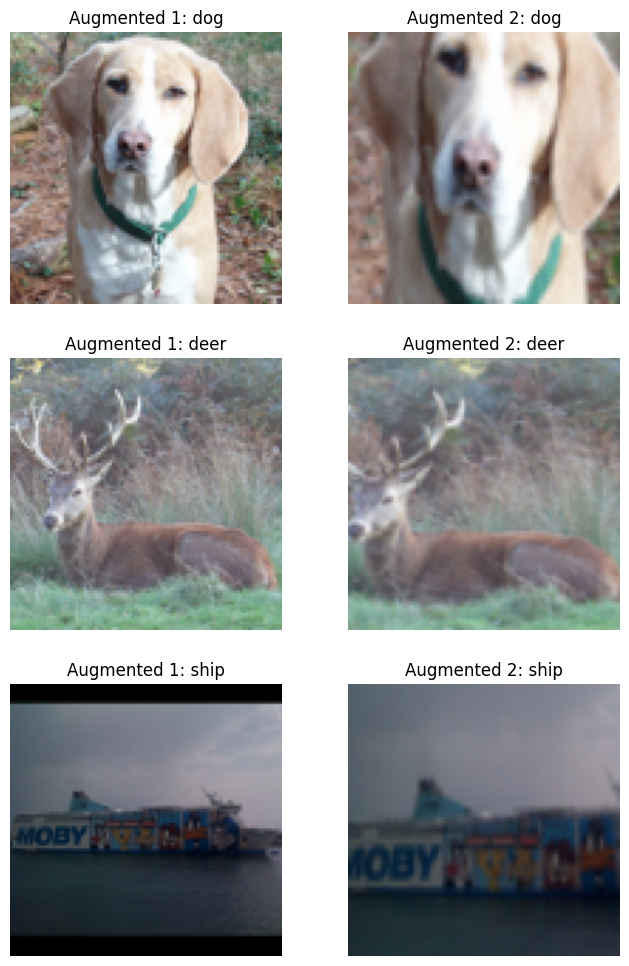

In [2]:
# 取得データの確認
import matplotlib.pyplot as plt

# サンプルループ（1バッチ分のデータを取得）
for batch in dataloader:
    augmented_1, augmented_2, labels = batch
    print(f"Augmented 1 shape: {augmented_1.shape}, Augmented 2 shape: {augmented_2.shape}")
    break

#next(iter(dataloader)) # num_workers と，next(iter(dataloader)) の組み合わせはデッドロックを生じさせる可能性あり
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
for i in range(3):
    ax[i, 0].imshow(augmented_1[i].permute(1, 2, 0))
    ax[i, 1].imshow(augmented_2[i].permute(1, 2, 0))
    ax[i, 0].set_title(f"Augmented 1: {labels_map[labels[i].item()]}")
    ax[i, 1].set_title(f"Augmented 2: {labels_map[labels[i].item()]}")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    

ネットワークの構成としては，表現を得るためのモデル(`encoder`)と，その表現を投影し似ているかどうかを判定するためのモデル(`projector`)を規定します．

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, W, H):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # 3xWxH -> 64xWxH
            nn.ReLU(),
            nn.MaxPool2d(2), # 64xWxH -> 64x(W/2)x(H/2)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x(W/4)x(H/4)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x(W/8)x(H/8)
            nn.Flatten() # 64x(W/8)x(H/8) -> 64*(W/8)*(H/8)
        )
        self.projector = nn.Sequential(
            nn.Linear(64*(W//8)*(H//8), 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.projector(x)
        return x

損失関数は，投影された先の特徴量間の類似度を,正例の場合は大きく，負例の場合は小さくなるように設計します．
これは NT-Xent 関数と呼ばれ，下記のように定義されます．

In [4]:
# NT-Xent Loss の実装例
# 同じ画像から作られたペア→正例
# 異なる画像から作られたペア→負例
# 正例同士は似て，負例同士は異なるようにロスを設計する

def nt_xent_loss(z1, z2, temperature):
    z = torch.cat([z1, z2], dim=0)
    n = z.size(0)
    sim_matrix = torch.matmul(z, z.T) / temperature
    # 数値安定性を考慮して，行の最大値を基準に差っ引いとく
    sim_matrix = sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0]
    sim_matrix = torch.exp(sim_matrix)

    # 対角成分は同じ画像同士の類似度なので正例，それ以外が負例
    mask = (torch.ones_like(sim_matrix) - torch.eye(n, device=sim_matrix.device)).bool()
    pos_sim = sim_matrix[range(n), range(n)]
    neg_sim = sim_matrix[mask].reshape(n, -1)

    loss = -torch.log(pos_sim / (pos_sim + neg_sim.sum(dim=-1)))
    loss = loss.mean()
    return loss



さらに学習ループは，下記のようにかきます．

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(W, H).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = [] # 学習履歴
num_epochs = 10 # エポック数，性能に合わせて調整

for epoch in range(num_epochs):
    for (images1, images2, _) in dataloader:
        images1, images2 = images1.to(device), images2.to(device)

        # 特徴抽出→projector
        z1 = model(images1)
        z2 = model(images2)

        # 類似性損失の計算
        # targets = torch.ones(z1.size(0)).to(z1.device)  # 正例ペア
        # loss = criterion(z1, z2, targets)
        
        # NT-Xent 損失を計算
        loss = nt_xent_loss(z1, z2, temperature=0.4)  # temperature はハイパーパラメータ

        history.append(loss.item())

        # 学習
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.7593863606452942
Epoch 2, Loss: 0.3399502635002136
Epoch 3, Loss: 5.88164220971521e-05
Epoch 4, Loss: 0.0017156339017674327
Epoch 5, Loss: 0.02714923769235611
Epoch 6, Loss: 0.059087079018354416
Epoch 7, Loss: 3.0249805149651365e-06
Epoch 8, Loss: 3.41244640367222e-06
Epoch 9, Loss: 0.11539100855588913
Epoch 10, Loss: 0.06279460340738297


多分，これでなんとか回って，ロスが下がるはずです．

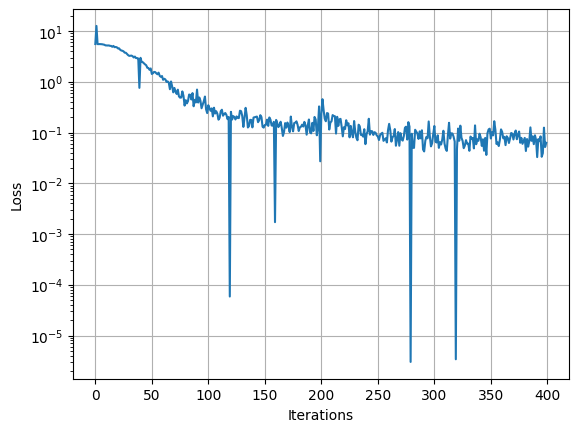

In [8]:
# history のプロット
plt.semilogy(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()


`SimpleCNN.encoder` がうまく学習できていればよいな，と思って性能を測ってみます．

In [9]:
train_dataset = datasets.STL10(root="./data", split='train', download=True, transform=transform_original)
test_dataset = datasets.STL10(root="./data", split='test', download=True, transform=transform_original)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


Epoch 1, Loss: 2.0532782077789307
Epoch 2, Loss: 2.248763084411621
Epoch 3, Loss: 1.5136432647705078
Epoch 4, Loss: 2.078632116317749
Epoch 5, Loss: 1.6629853248596191
Epoch 6, Loss: 1.723835825920105
Epoch 7, Loss: 1.61869478225708
Epoch 8, Loss: 1.8449182510375977
Epoch 9, Loss: 1.0496788024902344
Epoch 10, Loss: 1.2827149629592896
Epoch 11, Loss: 1.667236089706421
Epoch 12, Loss: 1.604527235031128
Epoch 13, Loss: 1.394842267036438
Epoch 14, Loss: 1.4182764291763306
Epoch 15, Loss: 1.3877006769180298
Epoch 16, Loss: 1.60127854347229
Epoch 17, Loss: 1.2436482906341553
Epoch 18, Loss: 1.4843838214874268
Epoch 19, Loss: 1.534259557723999
Epoch 20, Loss: 1.5121350288391113
Epoch 21, Loss: 1.7005385160446167
Epoch 22, Loss: 1.3934568166732788
Epoch 23, Loss: 1.4695062637329102
Epoch 24, Loss: 0.8001595735549927
Epoch 25, Loss: 0.9746922850608826
Epoch 26, Loss: 0.9137434959411621
Epoch 27, Loss: 1.2513667345046997
Epoch 28, Loss: 1.2397304773330688
Epoch 29, Loss: 0.7203302383422852
Epoch

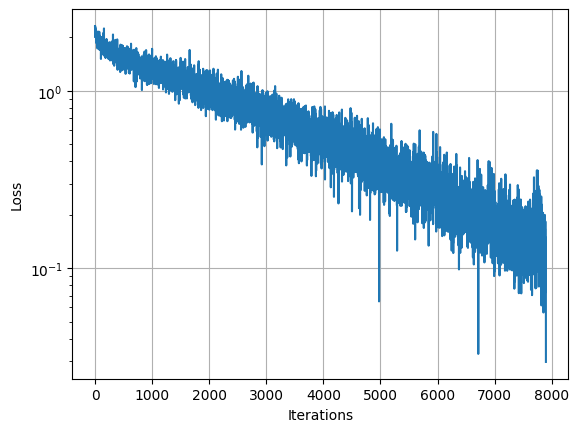

In [10]:
# 特徴抽出層は上で学習したものを固定して使う
for param in model.parameters():
    param.requires_grad = False

# 簡単な分類器を訓練 3層のMLP
classifier = nn.Sequential(
    nn.Linear(64*(W//8)*(H//8), 128),
    nn.ReLU(),
    nn.Linear(128, 10).to(device)
).to(device)

optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

history = []

# STL-10のラベルを使って学習
num_epochs = 100
for epoch in range(num_epochs):
    for (images, labels) in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = model.encoder(images)
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    
plt.semilogy(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()

Accuracy: 0.9866


Text(0.5, 1.0, 'Confusion Matrix0.9866')

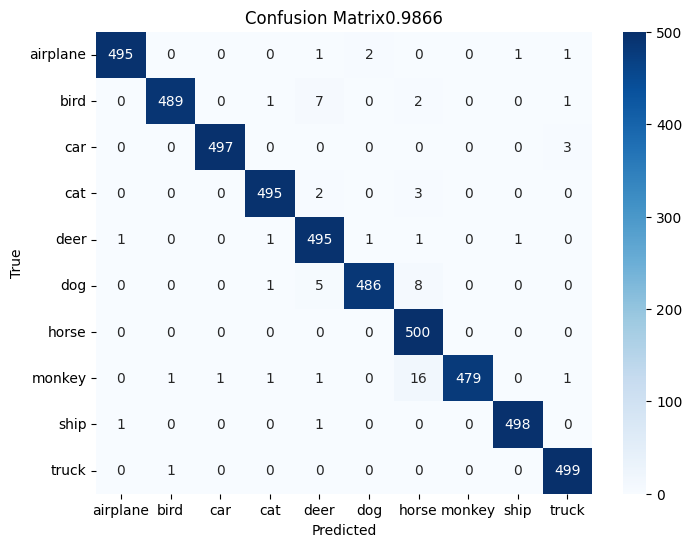

In [18]:
# 識別性能をテストデータ測る
# ついでに混同行列も作成

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix = np.zeros((10, 10))
with torch.no_grad():
    for (images, labels) in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = model.encoder(images)
        outputs = classifier(features)
        _, predicted = torch.max(outputs, 1)
        conf_matrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(10))

conf_matrix = np.array(conf_matrix, dtype=int)
correct = np.sum(np.diag(conf_matrix))
total = np.sum(conf_matrix)
print(f"Accuracy: {correct / total:.4f}")


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map, yticklabels=labels_map)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix{:.4f}".format(correct / total))


# 実験3-5

1. 自己教師あり学習による識別器を構成し，`CIFAR10` を用いた場合の識別性能を評価しなさい．（識別器はロジスティック回帰やSVM を用いて構わない）
2. 自己教師あり学習によって得られた `CIFAR10` の特徴表現を，PCA や t-SNE を用いて図示し，各クラスのデータが構造を持つかどうかを考察しなさい．
3. 自己教師あり学習によって得られた `CIFAR10` の特徴表現を k-means 法によりクラスタリングを行い，自己教師あり学習の特徴がクラスタリングに有効かどうかを評価しなさい．